## Forecast utilizando Prophet

Esse modelo considera tendência e sazonalidade de séries não estacionárias

In [3]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_components_plotly
import warnings
warnings.filterwarnings('ignore')

Importação dos dados sem transformação matemática

In [4]:
train = pd.read_csv('train.csv')
train['Data'] = pd.to_datetime(train['Data'])
train['ds'] = pd.to_datetime(train['ds'])
train.set_index('Data', inplace=True)
test = pd.read_csv('test.csv')
test['Data'] = pd.to_datetime(test['Data'])
test['ds'] = pd.to_datetime(test['ds'])
test.set_index('Data', inplace=True)
valid = pd.read_csv('valid.csv')
valid['Data'] = pd.to_datetime(valid['Data'])
valid['ds'] = pd.to_datetime(valid['ds'])
valid.set_index('Data', inplace=True)

Importação dos dados com transformação matemática

In [5]:
train_diff = pd.read_csv('train_diff.csv')
train_diff['ds'] = pd.to_datetime(train_diff['ds'])
train_diff['Data'] = pd.to_datetime(train_diff['Data'])
train_diff.set_index('Data', inplace=True)
test_diff = pd.read_csv('test_diff.csv')
test_diff['Data'] = pd.to_datetime(test_diff['Data'])
test_diff['ds'] = pd.to_datetime(test_diff['ds'])
test_diff.set_index('Data', inplace=True)
valid_diff = pd.read_csv('valid_diff.csv')
valid_diff['Data'] = pd.to_datetime(valid_diff['Data'])
valid_diff['ds'] = pd.to_datetime(valid_diff['ds'])
valid_diff.set_index('Data', inplace=True)

In [7]:
train.head()

,ds,y,unique_id
Data,,,
2004-01-02,2004-01-02,22.445,Fechamento
2004-01-03,2004-01-03,22.445,Fechamento
2004-01-04,2004-01-04,22.445,Fechamento
2004-01-05,2004-01-05,23.532,Fechamento
2004-01-06,2004-01-06,23.576,Fechamento


In [8]:
train_diff.head()

,y,ds,unique_id
Data,,,
2004-01-20,0.008034,2004-01-20,Fechamento
2004-01-21,-0.015231,2004-01-21,Fechamento
2004-01-22,-0.012220,2004-01-22,Fechamento
2004-01-23,0.021082,2004-01-23,Fechamento
2004-01-24,0.000416,2004-01-24,Fechamento


Funções para cálculo dos erros

In [6]:
def mape_error(y_true, y_pred):
    n = len(y_true)
    mape = (np.abs((y_true - y_pred) / y_true).sum() / n)
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2%}")
    return mape

def wmape_error(y_true, y_pred):
    wmape = np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
    print(f"WMAPE (Weighted Mean Absolute Percentage Error): {wmape:.2%}")
    return wmape

def smape_error(y_true, y_pred):
    smape = (np.abs(y_pred - y_true) * 2 / (np.abs(y_pred) + np.abs(y_true))).mean()
    print(f"SMAPE (Symmetric Mean Absolute Percentage Error): {smape:.2%}")
    return smape

Separação de dados de treino, teste e validação

Treinando modelo

In [9]:
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=7)
m.fit(train)
future = m.make_future_dataframe(periods=32,freq='B')

18:59:58 - cmdstanpy - INFO - Chain [1] start processing
19:00:03 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
m_diff = Prophet()
m_diff.add_seasonality(name='weekly', period=7, fourier_order=7)
m_diff.fit(train_diff)
future_diff = m_diff.make_future_dataframe(periods=32,freq='B')

19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:47 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
train.shape

(7120, 3)

In [28]:
train_diff.shape

(7087, 3)

In [12]:
future.shape

(7152, 1)

In [29]:
future_diff.shape

(7119, 1)

In [13]:
future.tail(5)

,ds
7147,2023-08-09
7148,2023-08-10
7149,2023-08-11
7150,2023-08-14
7151,2023-08-15


In [30]:
future_diff.tail(5)

,ds
7114,2023-08-09
7115,2023-08-10
7116,2023-08-11
7117,2023-08-14
7118,2023-08-15


In [14]:
test.tail(5)

,ds,y,unique_id
Data,,,
2023-08-11,2023-08-11,118.0650,Fechamento
2023-08-12,2023-08-12,118.6588,Fechamento
2023-08-13,2023-08-13,118.4785,Fechamento
2023-08-14,2023-08-14,116.8100,Fechamento
2023-08-15,2023-08-15,116.1710,Fechamento


In [31]:
test_diff.tail(5)

,y,ds,unique_id
Data,,,
2023-08-11,0.000703,2023-08-11,Fechamento
2023-08-12,-0.000917,2023-08-12,Fechamento
2023-08-13,-0.000650,2023-08-13,Fechamento
2023-08-14,-0.008448,2023-08-14,Fechamento
2023-08-15,-0.002653,2023-08-15,Fechamento


Previsão

In [21]:
prophet_forecast = m.predict(future)
prophet_future=prophet_forecast.tail(46)
prophet_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
7106,2023-06-17,112.609599,105.805872,119.908357
7107,2023-06-18,112.561367,105.648356,120.460837
7108,2023-06-19,112.469043,105.549665,119.711004
7109,2023-06-20,112.460114,104.958718,119.901053
7110,2023-06-21,112.433888,105.194786,120.209320
7111,2023-06-22,112.348753,104.402499,119.822492
7112,2023-06-23,112.271572,105.541798,120.287934
7113,2023-06-24,112.155258,104.375309,119.199592
7114,2023-06-25,112.101113,105.196027,119.576066
7115,2023-06-26,112.011086,104.771339,119.374029


In [32]:
prophet_forecast_diff = m_diff.predict(future_diff)
prophet_future_diff=prophet_forecast_diff.tail(46)
prophet_future_diff[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
7073,2023-06-17,-0.000819,-0.019834,0.017941
7074,2023-06-18,-0.000571,-0.019507,0.016802
7075,2023-06-19,-0.001611,-0.019081,0.016995
7076,2023-06-20,-0.000059,-0.019073,0.017845
7077,2023-06-21,-0.000278,-0.019427,0.019107
7078,2023-06-22,-0.000909,-0.020784,0.016191
7079,2023-06-23,-0.000345,-0.017427,0.017921
7080,2023-06-24,-0.000373,-0.018332,0.017765
7081,2023-06-25,0.000014,-0.018900,0.018069
7082,2023-06-26,-0.000898,-0.019360,0.017502


Plot dados originais

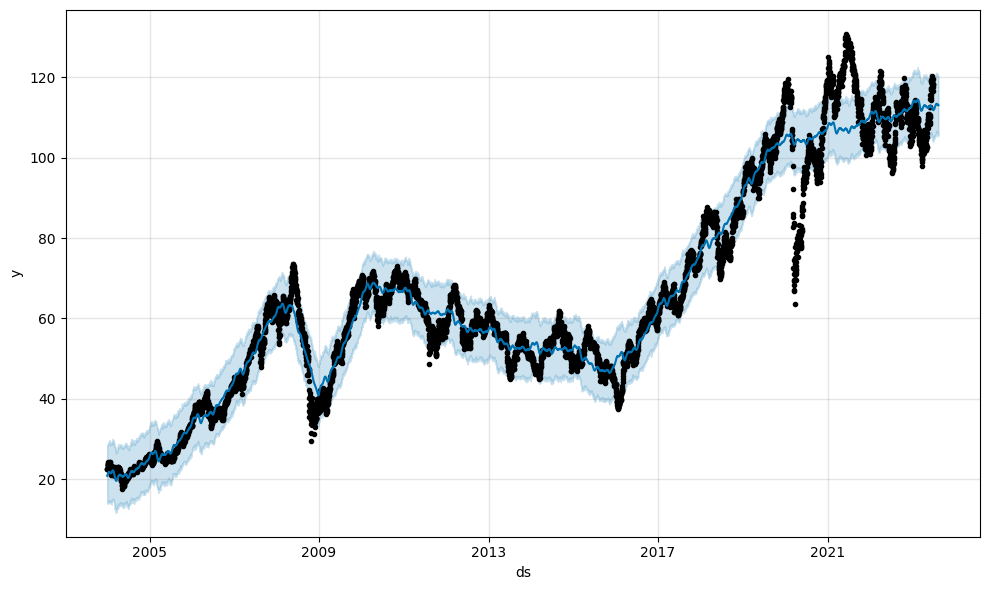

In [22]:
fig = m.plot(prophet_forecast)

In [23]:
plot_components_plotly(m, prophet_forecast)

Plot dados transformados

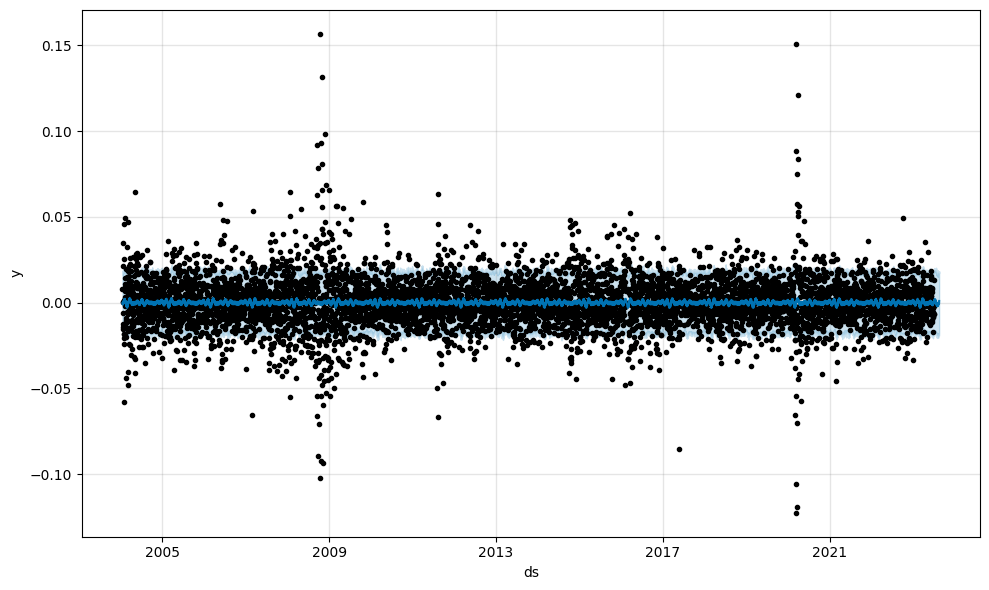

In [33]:
fig_diff = m_diff.plot(prophet_forecast_diff)

In [34]:
plot_components_plotly(m_diff, prophet_forecast_diff)

Avaliação

In [24]:
test['y'].values

array([117.7834 , 117.6685 , 119.673  , 119.076  , 119.549  , 117.426  ,
       118.898  , 118.9244 , 118.73725, 117.942  , 117.22   , 117.666  ,
       119.264  , 117.711  , 117.9606 , 117.96525, 118.219  , 117.841  ,
       117.552  , 118.083  , 120.217  , 118.3824 , 118.42325, 121.342  ,
       122.008  , 122.56   , 119.99   , 120.187  , 121.2174 , 121.18625,
       121.943  , 121.248  , 120.859  , 120.586  , 119.508  , 120.8288 ,
       120.55025, 119.38   , 119.09   , 118.409  , 118.35   , 118.065  ,
       118.6588 , 118.4785 , 116.81   , 116.171  ])

In [25]:
prophet_future['yhat'].values

array([112.60959926, 112.5613668 , 112.46904292, 112.46011429,
       112.43388798, 112.34875331, 112.27157198, 112.15525771,
       112.10111297, 112.0110855 , 112.01285871, 112.00576734,
       111.94805612, 111.90627036, 111.79418664, 111.85688569,
       111.91482591, 111.92512907, 111.95315006, 112.04885885,
       112.1761768 , 112.29446564, 112.35979299, 112.4365676 ,
       112.63346056, 112.77776626, 112.90423372, 112.96892779,
       113.03642735, 113.15779338, 113.2631409 , 113.34513085,
       113.360799  , 113.37576355, 113.32939715, 113.37911269,
       113.4073629 , 113.37214543, 113.33995365, 113.18162676,
       113.20561639, 113.21448152, 113.16633841, 113.12766216,
       112.98642138, 113.02700874])

In [26]:
model_names = ['Prophet']
mape_errors = [mape_error(test['y'].values, prophet_future['yhat'].values)]
wmape_errors = [wmape_error(test['y'].values, prophet_future['yhat'].values)]
smape_errors = [smape_error(test['y'].values, prophet_future['yhat'].values)]
df_error = pd.DataFrame({'model': model_names, 'mape': mape_errors, 'wmape': wmape_errors, 'smape': smape_errors})
df_error.to_csv('Data/ErrorsProphet.csv', index=False)

MAPE (Mean Absolute Percentage Error): 5.43%
WMAPE (Weighted Mean Absolute Percentage Error): 5.44%
SMAPE (Symmetric Mean Absolute Percentage Error): 5.58%


In [35]:
model_names_diff = ['Prophet']
mape_errors_diff = [mape_error(test_diff['y'].values, prophet_future_diff['yhat'].values)]
wmape_errors_diff = [wmape_error(test_diff['y'].values, prophet_future_diff['yhat'].values)]
smape_errors_diff = [smape_error(test_diff['y'].values, prophet_future_diff['yhat'].values)]
df_error_diff = pd.DataFrame({'model': model_names_diff, 'mape': mape_errors_diff, 'wmape': wmape_errors_diff, 'smape': smape_errors_diff})
df_error_diff.to_csv('Data/ErrorsProphet_diff.csv', index=False)

MAPE (Mean Absolute Percentage Error): 98.79%
WMAPE (Weighted Mean Absolute Percentage Error): 93.73%
SMAPE (Symmetric Mean Absolute Percentage Error): 148.97%
